In [1]:
%%capture
!pip install ht CoolProp fluids xlrd xlwt

In [ ]:
%matplotlib widget
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xlwt as xw
lista_data = []
import matplotlib.pyplot as plt
import ht,fluids,os,socket
import CoolProp as cp
from IPython.display import Latex
from prop_fluidos_intercambiadores import fluido_intercambiador
import time,datetime

## Intercambiador de Calor
#### HIPOTESIS DE CALCULO:


1. Intercambiador de calor a contracorriente de tubos concéntricos


In [ ]:
A = pd.read_csv('data1')
data2 = A.to_numpy()

In [ ]:
fig,ax = plt.subplots()
ax.plot(data2)
ax.plot(data2*0+data2.mean())
ax.set_ylim([0,2])


In [8]:
#datos valores sin flujo
PT01_ref,PT02_ref,PT03_ref,PT04_ref,PT05_ref,PT06_ref, = [6.55, -1.15, 1.4, 0.35, 6.15, -0.25]

In [9]:
#constantes de calculo
g = 9.8; cal2joule = 4.184
###########################################################
#           DATOS  del Intercambiador  
###########################################################
# Definición de Flujos
#Crudo = fluido_intercambiador('Crudo') 
#Glicol = fluido_intercambiador('Glycol')
# Temperaturas
T_crudo_e = 55.8 ##(al menos Twat + 20)
T_crudo_WAT = 32
T_crudo_s = T_crudo_WAT-10
T_crudo_s = 52.5

T_glycol_e = 38.8
T_glycol_s = 40
Caudal_crudo = 2.265 * 1e-3/60  #20L/min en m3/s

D_externo_1 = 33.44e-3

#Considerando Schedule 160 (para soportar 150psi)
espesor_tubo_1 = 6.35e-3

D_interno_1 = D_externo_1-2*espesor_tubo_1


D_externo_2 = 114.3e-3
espesor_tubo_2 = 6.02
#Supongo Schedule STD, presion de trabajo 40 psi
D_interno_2 = D_externo_2-2*espesor_tubo_2
Longitud = 16

In [15]:
A = pd.read_excel('150202_jd.xlsx',thousands=',')
A = pd.read_excel('150203.H24.xlsx',thousands=',')
A = pd.read_excel('DATOS DIESEL 17-08-2022.xlsx',thousands=',')
A = A[:944]
A.drop(A.columns[[1]],axis=1,inplace=True)

In [16]:
indices1 = np.logical_not(A['Date/Time'].isnull())
A1 = A[indices1]
indices2 = np.logical_not(A1['PT-01'].isnull())
A2 = A1[indices2]
indices3 = np.logical_not(np.logical_or(A2['PT-01'] == '???', A2['PT-01']=='?????'))
A3 = A2[indices3]


# variable tiempo
time1 = pd.to_datetime(A3['Date/Time'],errors='ignore').to_numpy()
time1 = [time1i.hour*3600+time1i.minute*60+time1i.second for time1i in time1]

#variables presion
PT01,PT02,PT03,PT04,PT05,PT06  = [pd.to_numeric(A3.iloc[:,i].to_numpy()) for i in range(1,7)]

PT01 = PT01 - PT01_ref
PT02 = PT02 - PT02_ref
PT03 = PT03 - PT03_ref
PT04 = PT04 - PT04_ref
PT05 = PT05 - PT05_ref
PT06 = PT06 - PT06_ref

# variables temperaturas
TE_s = np.tile(np.zeros_like(PT01),[12,1])
for i in range(9,21):
    TE_s[i-9] = pd.to_numeric(A3.iloc[:,i].to_numpy()) 
# variable caudal
# para -175 motor corresponde 2.465 l/min
Vmotor = pd.to_numeric(A3.iloc[:,30].to_numpy()) 
Tchiller_pv, Tchiller_sp = [pd.to_numeric(A3.iloc[:,i].to_numpy(),errors='ignore') for i in range(27,29)]
Tchiller_pv[Tchiller_pv =='???'] = np.NaN
Tchiller_sp[Tchiller_sp =='???'] = np.NaN

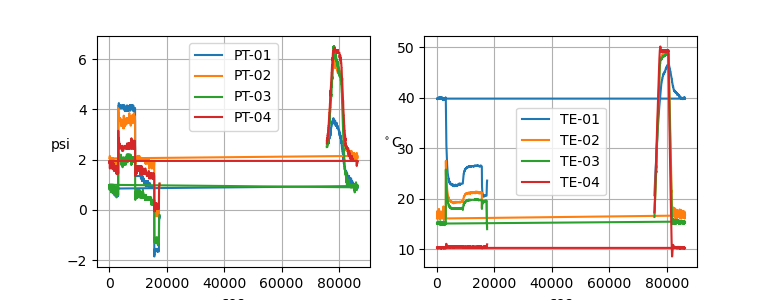

In [17]:
fig, ax = plt.subplots(1,2,figsize=(7.75,3))
ax1,ax2 = ax
ax1.plot(time1,PT01,label = 'PT-01')
ax1.plot(time1,PT02,label = 'PT-02')
ax1.plot(time1,PT03,label = 'PT-03')
ax1.plot(time1,PT04,label = 'PT-04')
ax1.grid()
ax1.set_ylabel('psi',rotation=0)
ax1.set_xlabel('sec')
ax1.legend();
ax2.plot(time1,TE_s[0],label = 'TE-01')
ax2.plot(time1,TE_s[1],label = 'TE-02')
ax2.plot(time1,TE_s[2],label = 'TE-03')
ax2.plot(time1,TE_s[11],label = 'TE-04')
ax2.grid()
ax2.set_ylabel(f'$^\circ$C',rotation=0)
ax2.set_xlabel('sec')
ax2.legend();

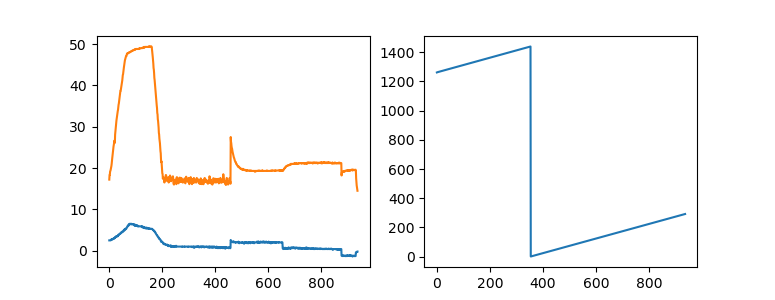

In [18]:
fig, ax = plt.subplots(1,2,figsize=(7.75,3))
ax1,ax2 = ax
ax1.plot(PT03,label = 'PT-01')
ax1.plot(TE_s[1],label = 'TE-02')
ax2.plot(np.asarray(time1)/60)
#delta t = 30segundos

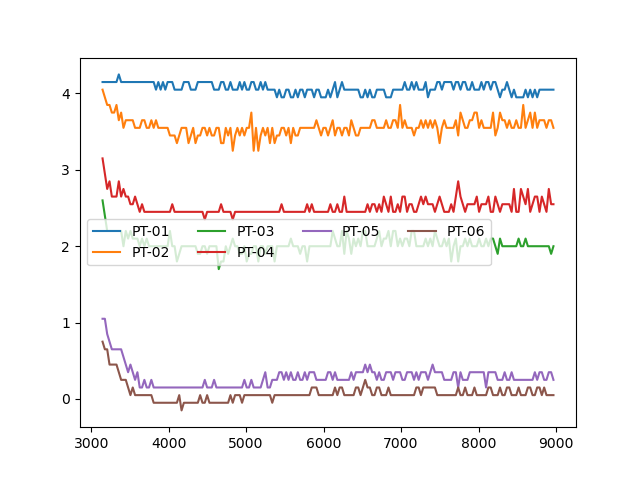

In [19]:
#EXPERIENCIA 1
# 458 HASTA 653
n_inicio,n_final = [458,653]
fig,ax = plt.subplots(clear=True)
ax.plot(time1[n_inicio:n_final],PT01[n_inicio:n_final],label='PT-01')
ax.plot(time1[n_inicio:n_final],PT02[n_inicio:n_final],label='PT-02');
ax.plot(time1[n_inicio:n_final],PT03[n_inicio:n_final],label='PT-03');
ax.plot(time1[n_inicio:n_final],PT04[n_inicio:n_final],label='PT-04');
ax.plot(time1[n_inicio:n_final],PT05[n_inicio:n_final],label='PT-05')
ax.plot(time1[n_inicio:n_final],PT06[n_inicio:n_final],label='PT-06')

ax.legend(ncol=4)

![Interfase ADQ](referencias.png)

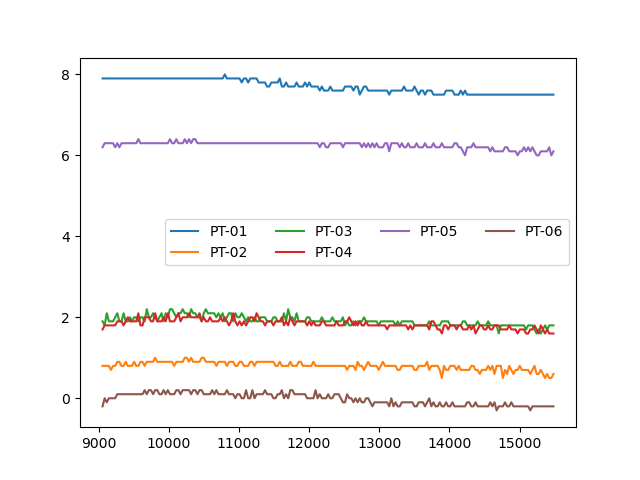

In [14]:
#EXPERIENCIA 2
# 655 HASTA 700
n_inicio,n_final = [655,870]
fig2,ax2 = plt.subplots(clear=True)
ax2.plot(time1[n_inicio:n_final],PT01[n_inicio:n_final],label='PT-01')
ax2.plot(time1[n_inicio:n_final],PT02[n_inicio:n_final],label='PT-02');
ax2.plot(time1[n_inicio:n_final],PT03[n_inicio:n_final],label='PT-03');
ax2.plot(time1[n_inicio:n_final],PT04[n_inicio:n_final],label='PT-04');
ax2.plot(time1[n_inicio:n_final],PT05[n_inicio:n_final],label='PT-05')
ax2.plot(time1[n_inicio:n_final],PT06[n_inicio:n_final],label='PT-06')

ax2.legend(ncol=4)

In [137]:
# Propiedades Físicas
T_crudo_media = (T_crudo_e+T_crudo_s)/2
T_glycol_media = (T_glycol_e+T_glycol_s)/2  # en caso de faltar un temperatura, tomar de la otra corriente

Cp_crudo = 2100 # [J/Kg K]
Cp_glycol = cp.CoolProp.PropsSI('C','T',273+T_glycol_media,'P',101325,'INCOMP::MEG[0.50]')
rho_crudo = 850
rho_glycol = cp.CoolProp.PropsSI('D','T',273+ T_glycol_media,'P',101325,'INCOMP::MEG[0.50]')
mu_crudo  = cp.CoolProp.PropsSI('V','T',273+T_crudo_media,'P',101325,'Water')*10
mu_glycol = cp.CoolProp.PropsSI('V','T',273+T_glycol_media,'P',101325,'INCOMP::MEG[0.50]')
nu_crudo = mu_crudo/rho_crudo
nu_glycol = mu_glycol/rho_glycol
k_crudo = 0.13
k_glycol = cp.CoolProp.PropsSI('L','T',273+T_glycol_media,'P',101325,'INCOMP::MEG[0.50]')
a_crudo = k_crudo/(rho_crudo*Cp_crudo)    #difusividad térmica
a_glycol = k_glycol/(rho_glycol*Cp_glycol)

Pr_crudo = nu_crudo/a_crudo
Pr_glycol = nu_glycol / a_glycol

Pr_glycol2 = cp.CoolProp.PropsSI('Prandtl','T',273+T_glycol_media,'P',101325,'INCOMP::MEG[0.50]')

[datos](https://material-properties.org/es/combustible-diesel-densidad-punto-de-fusion-conductividad-termica/)

In [14]:
Q_crudo = Cp_crudo*Caudal_crudo*rho_crudo*(T_crudo_e-T_crudo_s)
Q_glycol = Q_crudo
Caudal_glycol = Q_glycol / (Cp_glycol*(T_glycol_s-T_glycol_e) *rho_glycol)
display(Latex(f'Calor Intercambiado: $Q={Q_crudo*1e-3:.2f}$kW'))

<IPython.core.display.Latex object>

In [12]:
[Cp_crudo*Caudal_crudo*rho_crudo,Cp_glycol*Caudal_glycol*rho_glycol]

[67.38375, 185.30531249999945]

### Eficiencia térmica. Calor Intercambiado.

In [15]:
#Capacidad Térmica Mínima
Capacidades_termicas = np.array([Cp_crudo*Caudal_crudo*rho_crudo,Cp_glycol*Caudal_glycol*rho_glycol])
Fluidos = ['Crudo','Glycol']
Cmin = np.min(Capacidades_termicas)
fluido_cmin = Fluidos[np.argmin(Capacidades_termicas)]
#Mayor Salto Térmico del sistema
DeltaT_max = T_crudo_e- T_glycol_e
#Calor Máximo disponible
Qmax = Cmin*DeltaT_max
#ficiencia térmica
eficiencia = Q_crudo/Qmax

 
print(f'Capacidad Térmica Mínima Cmin = %.1f W/K'%Cmin)
print(f'Fluido Cmin: '+fluido_cmin)
print(f'Calor Máximo disponible Qmax=%.1f kW'%(Qmax*1e-3))
print(f'Eficiencia térmica del equipo = %.2f'%eficiencia)


Capacidad Térmica Mínima Cmin = 67.4 W/K
Fluido Cmin: Crudo
Calor Máximo disponible Qmax=1.1 kW
Eficiencia térmica del equipo = 0.19


## LMTD, área y Coeficiente Global 


In [17]:
LMTD = ht.LMTD(Tci=T_glycol_e, Tco=T_glycol_s, Thi=T_crudo_e, Tho=T_crudo_s)

Area = D_interno*np.pi*Longitud
#######################
U = Q_crudo/(LMTD*Area)

display(Latex(f'Conductancia Global U={U:.1f}W/m$^2$'))

Area_pasaje_crudo = (D_interno**2*np.pi/4)
Veloc_crudo = Caudal_crudo / Area_pasaje_crudo

Area_pasaje_glycol = ( (D_externo**2-D_interno**2)*np.pi/4)
Perimetro_glycol = D_interno*np.pi+D_externo*np.pi

Veloc_glycol  = Caudal_glycol / Area_pasaje_glycol


D_hidraulico_glycol = 4*Area_pasaje_glycol / Perimetro_glycol

display(Latex(f'Velocidad crudo $V_{{crudo}}={Veloc_crudo:.3f}$m/s'))
display(Latex(f'Velocidad crudo $V_{{glycol}}={Veloc_glycol:.3f}$m/s'))


#Aire.veloc = Aire.caudal / Aire.area
#Aire.Reynolds()
#Npasotubos =  Re_design*(np.pi*Tubo_dext-Tubo_esp*2*Ntubos_0*m ) / (4*m_t)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

ŽUKAUSKAS, A. Heat transfer from tubes in crossflow. En Advances in heat transfer. Elsevier, 1972. p. 93-160.

In [18]:
Re_crudo = Veloc_crudo * D_interno / nu_crudo
Re_glycol = Veloc_glycol * D_hidraulico_glycol / nu_glycol
Nu_crudo = ht.conv_internal.turbulent_Colburn(Re_crudo,Pr_crudo)
Nu_glycol = ht.conv_internal.turbulent_Colburn(Re_glycol,Pr_glycol)
hc_crudo = Nu_crudo*k_crudo/D_interno
hc_glycol = Nu_glycol*k_glycol/D_hidraulico_glycol
display(Latex(f'$Re_{{crudo}}={Re_crudo:.0f}$,$Nu_{{crudo}}={Nu_crudo:.1f}$, $hc_{{crudo}}={hc_crudo:.0f}$'))
display(Latex(f'$Re_{{glycol}}={Re_glycol:.0f}$,    $Nu_{{glycol}}={Nu_glycol:.1f}$,$hc_{{glycol}}={hc_glycol:.0f}$'))
#print('Coeficiente conveccion aire = %.1f'%Aire.hc)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

COLBURN, Allan P. A method of correlating forced convection heat-transfer data and a comparison with fluid friction. International Journal of Heat and Mass Transfer, 1964, vol. 7, no 12, p. 1359-1384.

In [21]:
k_acero = ht.k_material('stainless steel')
espesor_tubo = 1e-3

In [22]:
Ulimpio = (1/ (hc_crudo*D_interno) + np.log((D_interno+espesor_tubo)/D_interno)/k_acero + 1/(hc_glycol*(D_interno+espesor_tubo)))**-1
#U_calc = 1 / (1/Ulimpio + Rf *(1+Tubo_dext/Tubo_dint))



In [23]:
1/ (np.log((D_interno+espesor_tubo)/D_interno)/k_acero ), (hc_crudo*D_interno) 

(440.2452970082708, 1.2961839923607767)

In [22]:
Ulimpio,hc_crudo

(4.270114968579573, 1531.9786379170362)

In [24]:
# Caida de presion

# Calculo para flujo en tubos
roughness = fluids.roughness_Farshad('Carbon steel, bare', D=D_interno)
roughness_gl = fluids.roughness_Farshad('Carbon steel, bare', D=D_hidraulico_glycol)

f_c = fluids.friction.friction_factor(Re=Re_crudo, eD=roughness/D_interno)
f_c2 = 1.2*(0.0014+0.125/Re_crudo**.32)
f_c_gl = fluids.friction.friction_factor(Re=Re_glycol, eD=roughness_gl/D_hidraulico_glycol)

Delta_p_crudo = f_c*Veloc_crudo**2*Longitud/D_interno/2 
Delta_p_glycol = f_c_gl*Veloc_glycol**2*Longitud/D_hidraulico_glycol/2 

display(Latex(f'$\Delta p_{{crudo}}={Delta_p_crudo}$Pa'))
display(Latex(f'$\Delta p_{{glycol}}={Delta_p_glycol}$Pa'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [13]:
print('Se puede volcar sobre un archivo Excel.')
# Workbook is created 
wb = xw.Workbook() 
xw.add_palette_colour("gris", 0x21)
wb.set_colour_RGB(0x21, 200, 200,200)  
# add_sheet is used to create sheet. 
sheet1 = wb.add_sheet('Performance Unidad') 
style = xw.easyxf('pattern: pattern solid, fore_colour gris;')
# Input data into rows 
sheet1.write(3, 0, 'Nombre Fluido') 
sheet1.write(3, 1, 'Crudo') 
sheet1.write(3, 2, 'Glycol 50%') 

sheet1.write(4, 0, 'Caudal masico (kg/s)',style) 
sheet1.write(4, 1, '%.2f'%(Caudal_crudo*rho_crudo),style) 
sheet1.write(4, 2, '%.2f'%(Caudal_glycol*rho_glycol),style) 

sheet1.write(5, 0, 'Temperatura Entrada') 
sheet1.write(5, 1, '%.1f'%T_crudo_e) 
sheet1.write(5, 2, '%.1f'%T_glycol_e) 

sheet1.write(6, 0, 'Temperatura salida',style) 
sheet1.write(6, 1, f'{T_crudo_s:.1f}',style) 
sheet1.write(6, 2, f'{T_glycol_s:.1f}',style) 
sheet1.write(7, 0, 'Densidad kg/m3') 
sheet1.write(7, 1, f'{rho_crudo:.0f}')
sheet1.write(7, 2, f'{rho_glycol:.0f}')
sheet1.write(8, 0, 'Viscosidad cP',style) 
sheet1.write(8, 1, f'{mu_crudo*1e3:.1f}',style) 
sheet1.write(8, 2, f'{mu_glycol*1e3:.1f}',style) 


sheet1.write(9, 0, 'Calor específico J/Kg C')
sheet1.write(9, 1, f'{Cp_crudo:.0f}')
sheet1.write(9, 2, f'{Cp_glycol:.0f}')


sheet1.write(10, 0, 'Conductividad térmica W/Kg C',style) 
sheet1.write(10, 1, f'{k_crudo:.2f}',style) 
sheet1.write(10, 2, f'{k_glycol:.2f}',style) 

sheet1.write(11, 0, 'Presión de entrada kPa') 
sheet1.write(11, 1, '%.1f'%(101.3))
sheet1.write(11, 2, '%.1f'%(101.3))


sheet1.write(12, 0, 'Velocidad m/s',style) 
sheet1.write(12, 1, f'{Veloc_crudo:.1f}',style)
sheet1.write(12, 2, f'{Veloc_glycol:.1f}',style)


sheet1.write(13, 0, 'Caída de presión Pa') 
sheet1.write(13, 1, f'{Delta_p_crudo:.1f}')
sheet1.write(13, 2, f'{Delta_p_glycol:.1f}')


sheet1.write(14, 0, 'Resistencia de ensuciamiento m2C/W',style) 
#sheet1.write(14, 1, '%.4f'%(Rf/2),style)
#sheet1.write(14, 2, '%.4f'%(Rf/2),style)

sheet1.write(15, 0, 'Calor intercambiado kW') 
sheet1.write(15, 1, f'{Q_crudo*1e-3}')

sheet1.write(16, 0, 'Coeficiente Global de Transferencia',style)
sheet1.write(16, 1, f'{U:.1f}',style)

nombre_salida = 'Intercambiador_salida.xls'
wb.save(nombre_salida)
data_salida_excel = pd.read_excel('./'+nombre_salida,skiprows=2)
data_salida_excel

Se puede volcar sobre un archivo Excel.


,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,Nombre Fluido,Crudo,Glycol 50%
1,Caudal masico (kg/s),0.28,0.29
2,Temperatura Entrada,60.0,-20.0
3,Temperatura salida,22.0,5.0
4,Densidad kg/m3,850,1078
5,Viscosidad cP,6.4,11.4
6,Calor específico J/Kg C,2100,3159
7,Conductividad térmica W/Kg C,0.13,0.37
8,Presión de entrada kPa,101.3,101.3
9,Velocidad m/s,4.7,0.6


In [25]:
calcular volumen de parafina necesario.... tres veces lo que deposita 5mm en la pared

SyntaxError: invalid syntax (2619805294.py, line 1)

In [28]:
Diam = 25.4e-3
Diam_para = 25.4e-3-2.5e-3

Vol_para = (Diam**2*np.pi/4-Diam_para**2*np.pi/4)*Longitud

In [29]:
Vol_para*1e3

1.5173892516838692